# Campus Waste Intelligence System
## Joint Prediction and Optimization of Waste Generation and Contamination
### Focus: Forecasting Food Waste (lbs) per Campus Location

This notebook implements a rigorous time series forecasting pipeline to predict daily food waste for each canteen location. It integrates extensive data analysis, statistical testing, feature engineering, and multiple modeling approaches with proper temporal validation.

---
## 1. Setup and Imports

In [42]:
!pip install pmdarima

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# Statistical & time-series tools
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats

In [46]:
# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [47]:
# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [48]:
# Specialized forecasting
import pmdarima as pm
from prophet import Prophet
import itertools

In [49]:
# Plot settings
plt.style.use('ggplot')
sns.set_palette('husl')
%matplotlib inline

In [50]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change to your own directory
try:
    os.chdir("/content/drive/MyDrive/UAB/FDS/campus-waste-intelligence")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Mounted at /content/drive
Directory changed


---
## 2. Data Loading and Initial Preparation

In [51]:
# Load the cleaned dataset from the EDA stage
df = pd.read_csv('data/food_waste_cleaned.csv', parse_dates=['Date'])
print('Data shape:', df.shape)
df.head()

Data shape: (2600, 23)


,Date,Meal,Canteen_Section,Food_Category,Waste_Weight_kg,Unit_Price_per_kg,Cost_Loss,Year,Month,Day,...,Quarter,IsWeekend,Is_Waste_Outlier,Is_Cost_Outlier,Is_High_Waste,Is_High_Cost,Month_Name,Weekday_Type,Waste_per_Price,Log_Waste
0,2025-06-11,Breakfast,B,Vegetables,1.81,3.0,5.430,2025,6,11,...,2,False,False,False,False,False,June,Weekday,0.603333,1.033184
1,2025-06-11,Lunch,B,Soup,3.32,1.5,4.980,2025,6,11,...,2,False,False,False,False,False,June,Weekday,2.213333,1.463255
2,2025-06-11,Dinner,B,Soup,1.27,1.5,1.905,2025,6,11,...,2,False,False,False,False,False,June,Weekday,0.846667,0.819780
3,2025-06-11,Lunch,D,Soup,1.10,1.5,1.650,2025,6,11,...,2,False,False,False,False,False,June,Weekday,0.733333,0.741937
4,2025-06-11,Dinner,D,Meat,4.57,8.0,36.560,2025,6,11,...,2,False,False,True,True,True,June,Weekday,0.571250,1.717395


In [52]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2600 non-null   datetime64[ns]
 1   Meal               2600 non-null   object        
 2   Canteen_Section    2600 non-null   object        
 3   Food_Category      2600 non-null   object        
 4   Waste_Weight_kg    2600 non-null   float64       
 5   Unit_Price_per_kg  2600 non-null   float64       
 6   Cost_Loss          2600 non-null   float64       
 7   Year               2600 non-null   int64         
 8   Month              2600 non-null   int64         
 9   Day                2600 non-null   int64         
 10  Weekday            2600 non-null   object        
 11  Week               2600 non-null   int64         
 12  DayOfYear          2600 non-null   int64         
 13  Quarter            2600 non-null   int64         
 14  IsWeeken

In [53]:
# Check for missing values
print('Missing values:')
df.isnull().sum()

Missing values:


,0
Date,0
Meal,0
Canteen_Section,0
Food_Category,0
Waste_Weight_kg,0
Unit_Price_per_kg,0
Cost_Loss,0
Year,0
Month,0
Day,0


---
## 3. Data Aggregation and Time Series Creation

We forecast daily total waste (in kg) per canteen section.  
First, aggregate daily sums per location.

In [54]:
# Daily waste per section
daily_section = (
    df.groupby(['Date', 'Canteen_Section'])['Waste_Weight_kg']
    .sum()
    .reset_index()
)
daily_section.rename(columns={'Waste_Weight_kg': 'Total_Waste_kg'}, inplace=True)

print('Aggregated shape:', daily_section.shape)
daily_section.head()

Aggregated shape: (244, 3)


,Date,Canteen_Section,Total_Waste_kg
0,2025-06-11,A,29.90
1,2025-06-11,B,26.85
2,2025-06-11,C,27.72
3,2025-06-11,D,37.59
4,2025-06-12,A,32.99


In [55]:
# Pivot to have sections as columns
daily_wide = (
    daily_section
    .pivot(index='Date', columns='Canteen_Section', values='Total_Waste_kg')
    .fillna(0)
)
daily_wide.sort_index(inplace=True)

print('Daily data shape:', daily_wide.shape)
daily_wide.head()

Daily data shape: (61, 4)


Canteen_Section,A,B,C,D
Date,,,,
2025-06-11,29.90,26.85,27.72,37.59
2025-06-12,32.99,34.36,33.39,31.45
2025-06-13,32.99,28.56,30.40,31.51
2025-06-14,21.74,26.84,35.79,32.74
2025-06-15,30.39,32.22,29.09,32.40


In [56]:
# For univariate time series analysis, pick the section with most data (e.g., 'B')
ts = daily_wide['B'].copy()
ts = ts.asfreq('D')  # ensure daily frequency
ts = ts.fillna(0)    # fill missing days with 0 (no waste recorded)

print(f'Time series for section B:')
print(f'  Start : {ts.index[0]}')
print(f'  End   : {ts.index[-1]}')
print(f'  Length: {len(ts)}')

Time series for section B:
  Start : 2025-06-11 00:00:00
  End   : 2025-08-10 00:00:00
  Length: 61


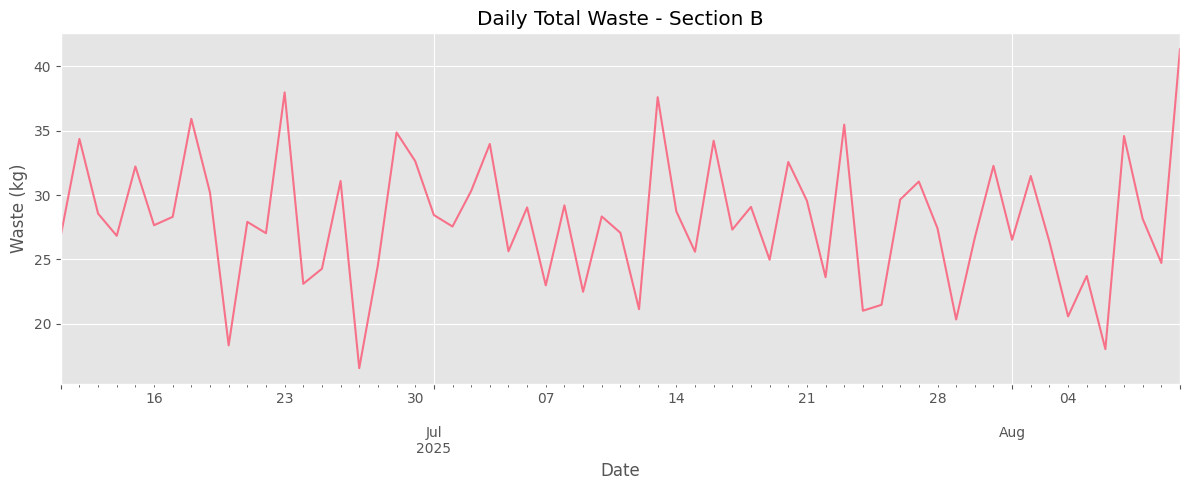

In [57]:
ts.plot(figsize=(12, 5), title='Daily Total Waste - Section B')
plt.ylabel('Waste (kg)')
plt.tight_layout()
plt.show()

---
## 4. Deep Exploratory Data Analysis (EDA)

### 4.1 Univariate Analysis

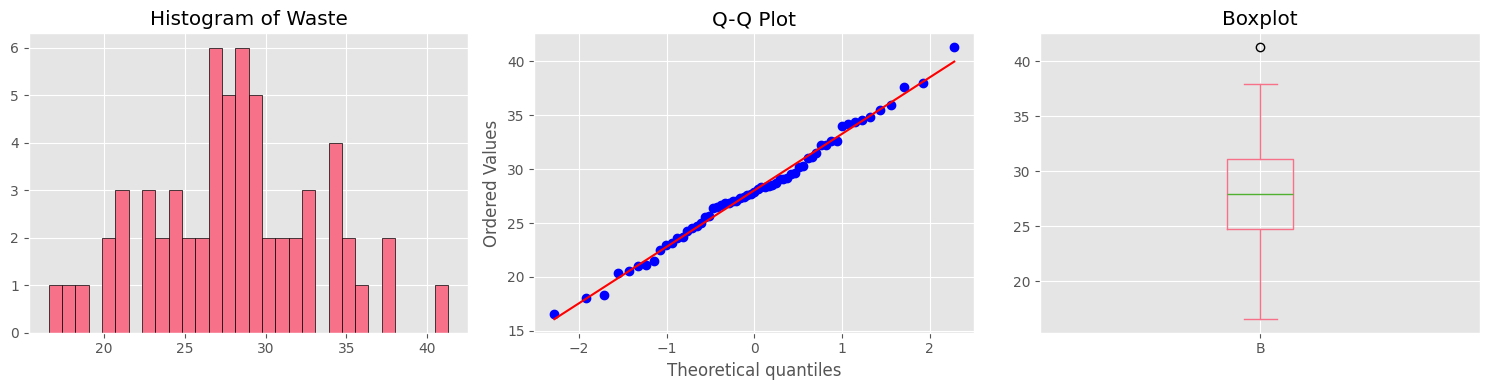

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ts.hist(ax=axes[0], bins=30, edgecolor='black')
axes[0].set_title('Histogram of Waste')

stats.probplot(ts, dist='norm', plot=axes[1])
axes[1].set_title('Q-Q Plot')

ts.plot(kind='box', ax=axes[2])
axes[2].set_title('Boxplot')

plt.tight_layout()
plt.show()

In [59]:
# Skewness and Kurtosis
print(f'Skewness: {ts.skew():.3f}')
print(f'Kurtosis: {ts.kurtosis():.3f}')
# Positive skew -> right tail; high kurtosis -> heavy tails

Skewness: 0.111
Kurtosis: -0.003


### 4.2 Stationarity Testing

We apply Augmented Dickey-Fuller (ADF) and KPSS tests.

In [60]:
def stationarity_tests(series: pd.Series) -> None:
    """Run ADF and KPSS stationarity tests and print results."""

    # --- ADF test ---
    adf_result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic : {adf_result[0]:.6f}')
    print(f'p-value       : {adf_result[1]:.6f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'  {key}: {value:.3f}')
    if adf_result[1] <= 0.05:
        print('=> Reject H0 (series is stationary)\n')
    else:
        print('=> Fail to reject H0 (non-stationary)\n')

    # --- KPSS test ---
    kpss_result = kpss(series, regression='c', nlags='auto')
    print(f'KPSS Statistic: {kpss_result[0]:.6f}')
    print(f'p-value       : {kpss_result[1]:.6f}')
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print(f'  {key}: {value:.3f}')
    if kpss_result[1] > 0.05:
        print('=> Fail to reject H0 (series is stationary)')
    else:
        print('=> Reject H0 (non-stationary)')

In [61]:
print('=== Stationarity tests for ORIGINAL series ===')
stationarity_tests(ts)

=== Stationarity tests for ORIGINAL series ===
ADF Statistic : -4.029914
p-value       : 0.001262
Critical Values:
  1%: -3.563
  5%: -2.919
  10%: -2.597
=> Reject H0 (series is stationary)

KPSS Statistic: 0.136932
p-value       : 0.100000
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
=> Fail to reject H0 (series is stationary)


In [62]:
# Apply first differencing
ts_diff = ts.diff().dropna()

print('=== Stationarity tests for DIFFERENCED series ===')
stationarity_tests(ts_diff)

=== Stationarity tests for DIFFERENCED series ===
ADF Statistic : -5.648568
p-value       : 0.000001
Critical Values:
  1%: -3.558
  5%: -2.917
  10%: -2.596
=> Reject H0 (series is stationary)

KPSS Statistic: 0.233331
p-value       : 0.100000
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
=> Fail to reject H0 (series is stationary)


### 4.3 Autocorrelation and Partial Autocorrelation

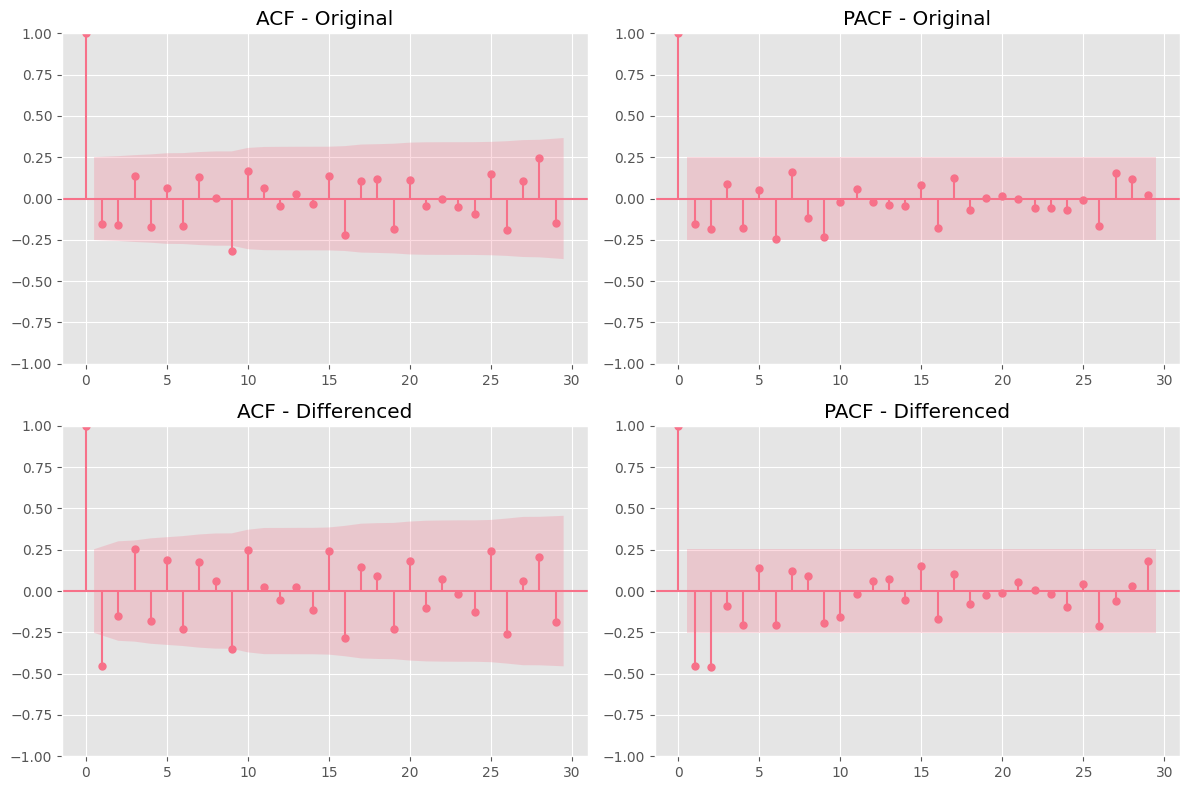

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(ts, ax=axes[0, 0], lags=29, title='ACF - Original')
plot_pacf(ts, ax=axes[0, 1], lags=29, title='PACF - Original')
plot_acf(ts_diff, ax=axes[1, 0], lags=29, title='ACF - Differenced')
plot_pacf(ts_diff, ax=axes[1, 1], lags=29, title='PACF - Differenced')

plt.tight_layout()
plt.show()

> **Observation:** Strong weekly seasonality (lag 7) is visible.

### 4.4 Seasonal Decomposition

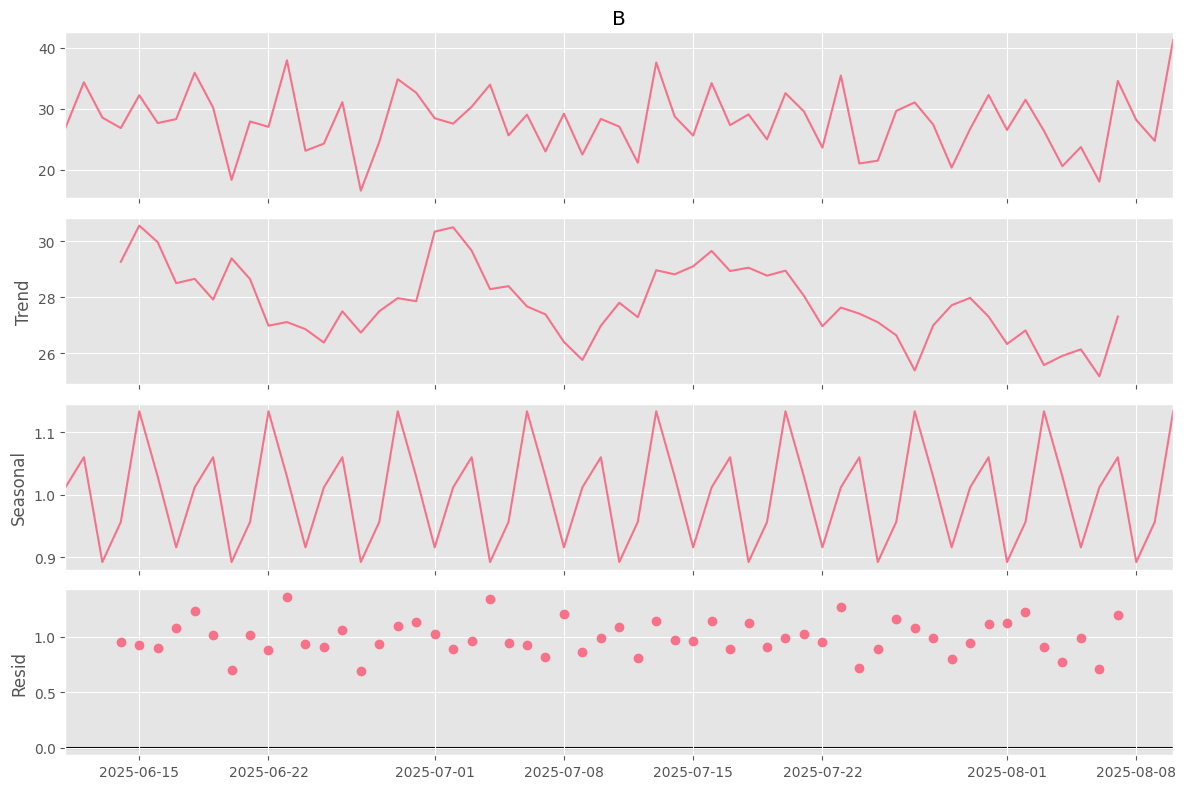

In [64]:
# Multiplicative decomposition (variance increases with level)
# Add epsilon to avoid log(0)
decomp = seasonal_decompose(ts + 1e-6, model='multiplicative', period=7)

fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

> **Observation:** Trend is relatively stable, strong weekly seasonality, residuals show some patterns but are mostly random.

### 4.5 Hypothesis Testing for Group Differences

We test whether waste differs significantly across meals, categories, and sections using Kruskal-Wallis (non-parametric ANOVA due to non-normality).

In [65]:
df_long = df[['Meal', 'Food_Category', 'Canteen_Section', 'Waste_Weight_kg']].copy()

In [66]:
# Kruskal-Wallis by Meal
groups_meal = [group['Waste_Weight_kg'].values for _, group in df_long.groupby('Meal')]
stat, p = stats.kruskal(*groups_meal)
print(f'Kruskal-Wallis by Meal: H={stat:.3f}, p={p:.4f}')
if p < 0.05:
    print('=> Significant differences across meals')

Kruskal-Wallis by Meal: H=7.862, p=0.0196
=> Significant differences across meals


In [67]:
# Kruskal-Wallis by Food_Category
groups_cat = [group['Waste_Weight_kg'].values for _, group in df_long.groupby('Food_Category')]
stat, p = stats.kruskal(*groups_cat)
print(f'Kruskal-Wallis by Food_Category: H={stat:.3f}, p={p:.4f}')
if p < 0.05:
    print('=> Significant differences across categories')

Kruskal-Wallis by Food_Category: H=5.682, p=0.1282


In [68]:
# Kruskal-Wallis by Canteen_Section
groups_sec = [group['Waste_Weight_kg'].values for _, group in df_long.groupby('Canteen_Section')]
stat, p = stats.kruskal(*groups_sec)
print(f'Kruskal-Wallis by Section: H={stat:.3f}, p={p:.4f}')
if p < 0.05:
    print('=> Significant differences across sections')

Kruskal-Wallis by Section: H=3.158, p=0.3679


### 4.6 Correlation Analysis

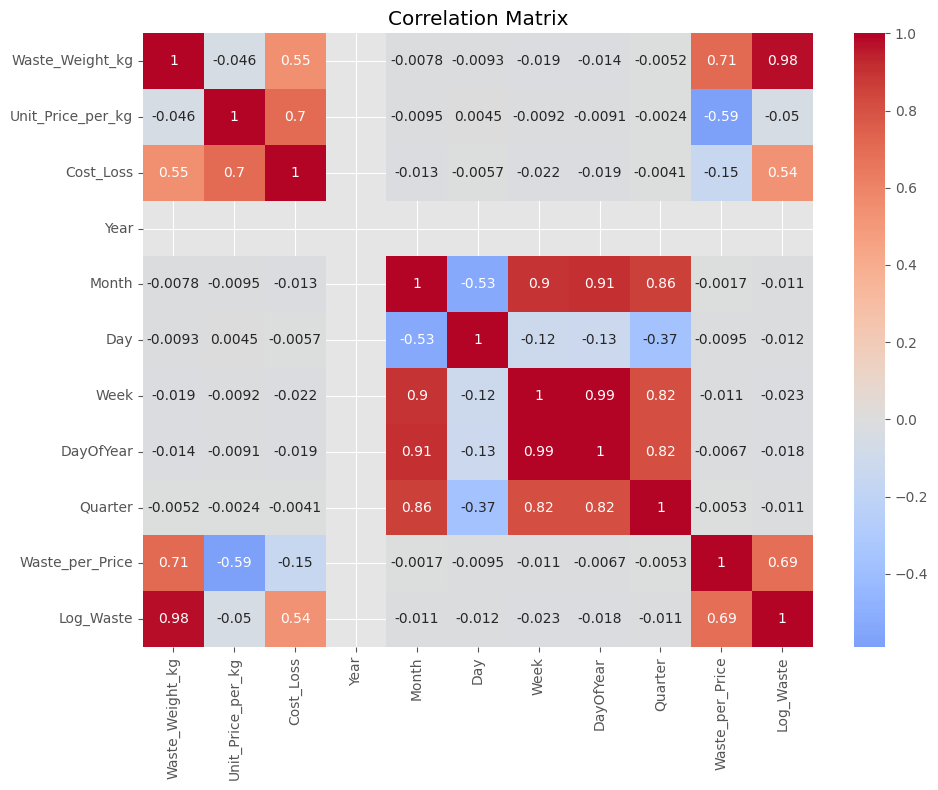

In [69]:
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

> `Cost_Loss` is highly correlated with `Waste_Weight_kg` and `Unit_Price_per_kg` - expected.

---
## 5. Feature Engineering for Machine Learning Models

In [70]:
# Create features from the daily aggregated data for section B
df_ml = pd.DataFrame(index=ts.index)
df_ml['y'] = ts.values

# Date features
df_ml['dayofweek'] = df_ml.index.dayofweek
df_ml['day']       = df_ml.index.day
df_ml['month']     = df_ml.index.month
df_ml['quarter']   = df_ml.index.quarter
df_ml['weekend']   = (df_ml.index.dayofweek >= 5).astype(int)

print('Date features added.')
df_ml.head()

Date features added.


,y,dayofweek,day,month,quarter,weekend
Date,,,,,,
2025-06-11,26.85,2,11,6,2,0
2025-06-12,34.36,3,12,6,2,0
2025-06-13,28.56,4,13,6,2,0
2025-06-14,26.84,5,14,6,2,1
2025-06-15,32.22,6,15,6,2,1


In [71]:
# Lag features (1, 2, 3, 7, 14 days)
for lag in [1, 2, 3, 7, 14]:
    df_ml[f'lag_{lag}'] = df_ml['y'].shift(lag)

print('Lag features added.')

Lag features added.


In [72]:
# Rolling statistics (7-day window, shifted by 1 to avoid leakage)
shifted = df_ml['y'].shift(1)

df_ml['rolling_mean_7'] = shifted.rolling(7).mean()
df_ml['rolling_std_7']  = shifted.rolling(7).std()
df_ml['rolling_min_7']  = shifted.rolling(7).min()
df_ml['rolling_max_7']  = shifted.rolling(7).max()

# Exponentially weighted moving average
df_ml['ewm_mean_7'] = shifted.ewm(span=7).mean()

print('Rolling & EWM features added.')

Rolling & EWM features added.


In [73]:
# Drop NaN rows (due to lags and rolling)
df_ml.dropna(inplace=True)

# Separate features and target
X = df_ml.drop('y', axis=1)
y = df_ml['y']

print(f'Feature matrix shape: {X.shape}')
X.head()

Feature matrix shape: (47, 15)


,dayofweek,day,month,quarter,weekend,lag_1,lag_2,lag_3,lag_7,lag_14,rolling_mean_7,rolling_std_7,rolling_min_7,rolling_max_7,ewm_mean_7
Date,,,,,,,,,,,,,,,
2025-06-25,2,25,6,2,0,23.11,37.97,27.04,35.92,26.85,28.640000,6.860578,18.33,37.97,28.341092
2025-06-26,3,26,6,2,0,24.28,23.11,37.97,30.19,34.36,26.977143,6.178737,18.33,37.97,27.312067
2025-06-27,4,27,6,2,0,31.09,24.28,23.11,18.33,28.56,27.105714,6.265490,18.33,37.97,28.266113
2025-06-28,5,28,6,2,1,16.56,31.09,24.28,27.92,26.84,26.852857,6.699372,16.56,37.97,25.317419
2025-06-29,6,29,6,2,1,24.56,16.56,31.09,27.04,32.22,26.372857,6.730467,16.56,37.97,25.126991


### 5.1 Train / Validation / Test Split (Time-Based)

We use expanding window for time series - no random shuffling.

In [74]:
# Define split dates
TRAIN_END = '2025-07-15'
VAL_END   = '2025-07-25'

X_train = X.loc[:TRAIN_END]
y_train = y.loc[:TRAIN_END]

X_val = X.loc[TRAIN_END:VAL_END].iloc[1:]   # exclude TRAIN_END row
y_val = y.loc[TRAIN_END:VAL_END].iloc[1:]

X_test = X.loc[VAL_END:].iloc[1:]
y_test = y.loc[VAL_END:].iloc[1:]

print(f'Train size: {len(X_train)}')
print(f'Val   size: {len(X_val)}')
print(f'Test  size: {len(X_test)}')

Train size: 21
Val   size: 10
Test  size: 16


---
## 6. Baseline Models

In [75]:
def evaluate(y_true, y_pred, name: str) -> dict:
    """Compute MAE, RMSE, MAPE, and SMAPE for a set of predictions."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mae   = mean_absolute_error(y_true, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
    mape  = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    smape = 100 * np.mean(
        2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-6)
    )
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'SMAPE': smape}

# Accumulator for all model results
results: list[dict] = []

In [76]:
# Naive (persistence) - previous day value
y_pred_naive = y_val.shift(1).bfill()
results.append(evaluate(y_val, y_pred_naive, 'Naive'))
print('Naive:', results[-1])

Naive: {'Model': 'Naive', 'MAE': 5.606, 'RMSE': np.float64(7.203513031847724), 'MAPE': np.float64(21.06502214228862), 'SMAPE': np.float64(19.56720644091036)}


In [77]:
# Seasonal naive - same day previous week
y_pred_snaive = y_val.shift(7).bfill()
results.append(evaluate(y_val, y_pred_snaive, 'Seasonal Naive (7d)'))
print('Seasonal Naive:', results[-1])

Seasonal Naive: {'Model': 'Seasonal Naive (7d)', 'MAE': 5.333999999999999, 'RMSE': np.float64(6.286635029966349), 'MAPE': np.float64(21.45062758573607), 'SMAPE': np.float64(18.58031814853092)}


In [78]:
# Moving average of last 7 days
y_pred_ma = X_val['rolling_mean_7']
results.append(evaluate(y_val, y_pred_ma, 'Moving Average (7d)'))
print('Moving Average:', results[-1])

Moving Average: {'Model': 'Moving Average (7d)', 'MAE': 4.313571428571429, 'RMSE': np.float64(5.070146055135706), 'MAPE': np.float64(16.49175731225702), 'SMAPE': np.float64(15.58040319821467)}


---
## 7. SARIMA Model

In [79]:
# Use auto_arima to find best SARIMA parameters
sarima_model = pm.auto_arima(
    y_train,
    seasonal=True,
    m=7,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
)
print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=inf, Time=8.63 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=97.668, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=95.637, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=3.35 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=95.672, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=99.435, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=inf, Time=6.48 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=97.626, Time=4.81 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=99.609, Time=2.31 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=93.831, Time=0.36 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=95.831, Time=0.75 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=95.831, Time=0.40 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=97.831, Time=0.44 sec
 ARIMA(0,0,1

In [80]:
# Forecast on validation set
forecast_sarima, conf_int = sarima_model.predict(
    n_periods=len(y_val), return_conf_int=True
)
y_pred_sarima = forecast_sarima

results.append(evaluate(y_val, y_pred_sarima, 'SARIMA'))
print('SARIMA:', results[-1])

SARIMA: {'Model': 'SARIMA', 'MAE': 5.189795246829268, 'RMSE': np.float64(6.172090919231208), 'MAPE': np.float64(18.916257350827614), 'SMAPE': np.float64(18.80573362479377)}


---
## 8. Prophet Model

In [81]:
# Prophet requires a DataFrame with columns 'ds' and 'y'
df_prophet_train = pd.DataFrame({'ds': y_train.index, 'y': y_train.values})

prophet_model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
)
prophet_model.fit(df_prophet_train)

INFO:prophet:n_changepoints greater than number of observations. Using 15.


In [82]:
future = prophet_model.make_future_dataframe(periods=len(y_val), include_history=False)
forecast_prophet = prophet_model.predict(future)
y_pred_prophet = forecast_prophet['yhat'].values

results.append(evaluate(y_val, y_pred_prophet, 'Prophet'))
print('Prophet:', results[-1])

Prophet: {'Model': 'Prophet', 'MAE': 4.716956140893103, 'RMSE': np.float64(5.862340284372963), 'MAPE': np.float64(17.051315141936147), 'SMAPE': np.float64(17.18286032582806)}


---
## 9. Machine Learning Models (XGBoost, Random Forest, SVM)

In [83]:
# Standardize features for SVM (tree models don't need scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [84]:
# --- XGBoost ---
xgb_model = xgb.XGBRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

results.append(evaluate(y_val, y_pred_xgb, 'XGBoost'))
print('XGBoost:', results[-1])

XGBoost: {'Model': 'XGBoost', 'MAE': 3.552608497619629, 'RMSE': np.float64(4.217831526442356), 'MAPE': np.float64(12.00760775514876), 'SMAPE': np.float64(12.822271039379856)}


In [85]:
# --- Random Forest ---
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=10, random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

results.append(evaluate(y_val, y_pred_rf, 'Random Forest'))
print('Random Forest:', results[-1])

Random Forest: {'Model': 'Random Forest', 'MAE': 4.050180000000003, 'RMSE': np.float64(4.848027166384285), 'MAPE': np.float64(14.13693286649185), 'SMAPE': np.float64(14.58489955061077)}


In [86]:
# --- SVM ---
svm_model = SVR(kernel='rbf', C=100, gamma='scale')
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_val_scaled)

results.append(evaluate(y_val, y_pred_svm, 'SVM'))
print('SVM:', results[-1])

SVM: {'Model': 'SVM', 'MAE': 4.052422971399353, 'RMSE': np.float64(4.645439465722094), 'MAPE': np.float64(14.063444179934843), 'SMAPE': np.float64(14.622810555425925)}


---
## 10. LSTM with PyTorch

In [87]:
def create_sequences(data, lookback: int = 7):
    """Create sliding-window sequences for the LSTM."""
    X_seq, y_seq = [], []
    for i in range(lookback, len(data)):
        X_seq.append(data[i - lookback : i])
        y_seq.append(data[i])
    return np.array(X_seq), np.array(y_seq)

In [88]:
class LSTMModel(nn.Module):
    """Simple 2-layer LSTM for univariate time series forecasting."""

    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # last time step
        out = self.fc(out)
        return out.squeeze()

In [89]:
# Hyperparameters
LOOKBACK   = 7
EPOCHS     = 100
BATCH_SIZE = 16
LR         = 0.001

# Build training sequences (univariate)
X_seq, y_seq = create_sequences(y_train.values, LOOKBACK)

X_tensor = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(-1)  # (N, seq, 1)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f'Training sequences: {X_tensor.shape[0]}')

Training sequences: 14


In [90]:
# Instantiate model, loss, and optimizer
lstm_model = LSTMModel()
criterion  = nn.MSELoss()
optimizer  = optim.Adam(lstm_model.parameters(), lr=LR)

# Training loop
for epoch in range(EPOCHS):
    lstm_model.train()
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        output = lstm_model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch + 1}/{EPOCHS}  |  Loss: {loss.item():.4f}')

Epoch 20/100  |  Loss: 709.6804
Epoch 40/100  |  Loss: 575.0778
Epoch 60/100  |  Loss: 487.7462
Epoch 80/100  |  Loss: 430.8181
Epoch 100/100  |  Loss: 382.8966


In [91]:
# Predict on validation set
lstm_model.eval()
with torch.no_grad():
    combined = np.concatenate([y_train.values, y_val.values])
    X_val_seq, _ = create_sequences(combined, LOOKBACK)
    X_val_seq = X_val_seq[-len(y_val):]
    X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32).unsqueeze(-1)
    y_pred_lstm = lstm_model(X_val_tensor).numpy()

results.append(evaluate(y_val, y_pred_lstm, 'LSTM'))
print('LSTM:', results[-1])

LSTM: {'Model': 'LSTM', 'MAE': 19.143756992340087, 'RMSE': np.float64(19.75791877403234), 'MAPE': np.float64(67.53302382535564), 'SMAPE': np.float64(102.53515242577338)}


---
## 11. Model Evaluation and Comparison

In [92]:
results_df = pd.DataFrame(results).sort_values('RMSE')
results_df

,Model,MAE,RMSE,MAPE,SMAPE
5,XGBoost,3.552608,4.217832,12.007608,12.822271
7,SVM,4.052423,4.645439,14.063444,14.622811
6,Random Forest,4.050180,4.848027,14.136933,14.584900
2,Moving Average (7d),4.313571,5.070146,16.491757,15.580403
4,Prophet,4.716956,5.862340,17.051315,17.182860
3,SARIMA,5.189795,6.172091,18.916257,18.805734
1,Seasonal Naive (7d),5.334000,6.286635,21.450628,18.580318
0,Naive,5.606000,7.203513,21.065022,19.567206
8,LSTM,19.143757,19.757919,67.533024,102.535152


In [93]:
# Map model names to their predictions
PRED_MAP = {
    'XGBoost':             y_pred_xgb,
    'Random Forest':       y_pred_rf,
    'SVM':                 y_pred_svm,
    'Prophet':             y_pred_prophet,
    'SARIMA':              y_pred_sarima,
    'LSTM':                y_pred_lstm,
    'Moving Average (7d)': y_pred_ma,
    'Seasonal Naive (7d)': y_pred_snaive,
    'Naive':               y_pred_naive,
}

best_model_name = results_df.iloc[0]['Model']
y_pred_best = PRED_MAP[best_model_name]

print(f'Best model: {best_model_name}')

Best model: XGBoost


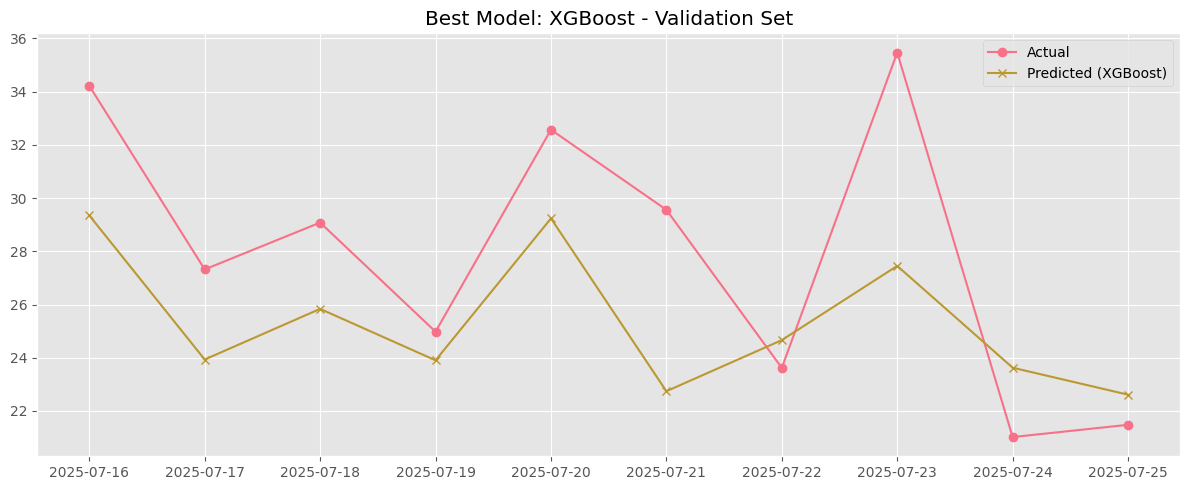

In [94]:
plt.figure(figsize=(12, 5))
plt.plot(y_val.index, y_val, label='Actual', marker='o')
plt.plot(y_val.index, y_pred_best, label=f'Predicted ({best_model_name})', marker='x')
plt.title(f'Best Model: {best_model_name} - Validation Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---
## 12. Residual Diagnostics

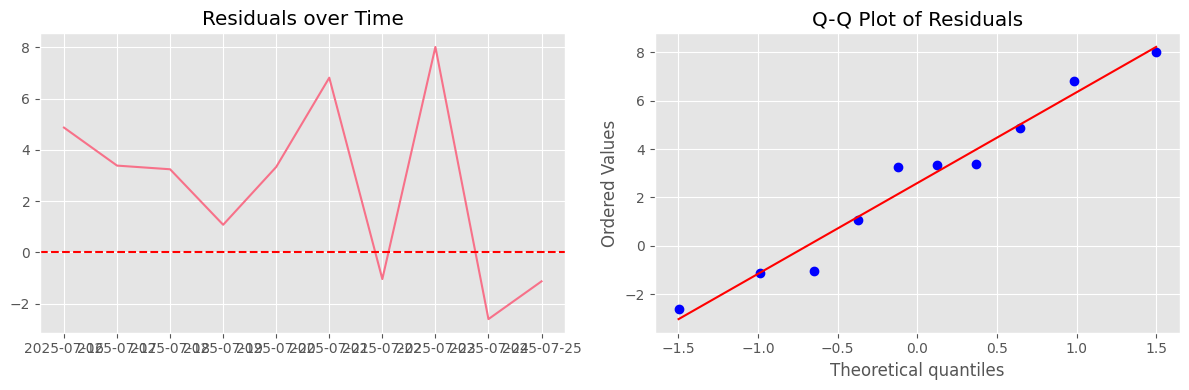

In [95]:
residuals = y_val - y_pred_best

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(residuals.index, residuals)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_title('Residuals over Time')

stats.probplot(residuals, dist='norm', plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

In [97]:
# Ljung-Box test for autocorrelation
lb_test = acorr_ljungbox(residuals, lags=[9], return_df=True)
print('Ljung-Box test (lag=9):')
print(lb_test)

Ljung-Box test (lag=9):
    lb_stat  lb_pvalue
9  5.415873   0.796654


In [98]:
# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f'Shapiro-Wilk: statistic={shapiro_stat:.3f}, p-value={shapiro_p:.4f}')
if shapiro_p > 0.05:
    print('Residuals appear normally distributed (fail to reject H0)')
else:
    print('Residuals are NOT normally distributed (reject H0)')

Shapiro-Wilk: statistic=0.954, p-value=0.7122
Residuals appear normally distributed (fail to reject H0)


---
## 13. Final Test Set Evaluation

Retrain the best model on combined train + validation data and evaluate on the held-out test set.

In [99]:
best_model_name = results_df.iloc[0]['Model']
print(f'Best model on validation: {best_model_name}')

# Combine train + val
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

Best model on validation: XGBoost


In [100]:
def retrain_and_predict_test(model_name):
    """Retrain the selected model on full training data and predict on test set."""

    if model_name == 'XGBoost':
        m = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
        m.fit(X_train_full, y_train_full)
        return m.predict(X_test)

    elif model_name == 'Random Forest':
        m = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
        m.fit(X_train_full, y_train_full)
        return m.predict(X_test)

    elif model_name == 'SVM':
        scaler_full = StandardScaler()
        Xf = scaler_full.fit_transform(X_train_full)
        Xt = scaler_full.transform(X_test)
        m = SVR(kernel='rbf', C=100, gamma='scale')
        m.fit(Xf, y_train_full)
        return m.predict(Xt)

    elif model_name == 'Prophet':
        df_p = pd.DataFrame({'ds': y_train_full.index, 'y': y_train_full.values})
        m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
        m.fit(df_p)
        future_t = m.make_future_dataframe(periods=len(y_test), include_history=False)
        return m.predict(future_t)['yhat'].values

    elif model_name == 'SARIMA':
        m = pm.auto_arima(
            y_train_full, seasonal=True, m=7,
            trace=False, error_action='ignore',
            suppress_warnings=True, stepwise=True,
        )
        return m.predict(n_periods=len(y_test))

    elif model_name == 'LSTM':
        X_sf, y_sf = create_sequences(y_train_full.values, LOOKBACK)
        Xt = torch.tensor(X_sf, dtype=torch.float32).unsqueeze(-1)
        yt = torch.tensor(y_sf, dtype=torch.float32)
        ds = TensorDataset(Xt, yt)
        dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

        m = LSTMModel()
        opt = optim.Adam(m.parameters(), lr=LR)
        for _ in range(EPOCHS):
            m.train()
            for Xb, yb in dl:
                opt.zero_grad()
                loss = criterion(m(Xb), yb)
                loss.backward()
                opt.step()

        combined_t = np.concatenate([y_train_full.values, y_test.values])
        X_ts, _ = create_sequences(combined_t, LOOKBACK)
        X_ts = X_ts[-len(y_test):]
        m.eval()
        with torch.no_grad():
            return m(torch.tensor(X_ts, dtype=torch.float32).unsqueeze(-1)).numpy()

    elif model_name == 'Moving Average (7d)':
        full = pd.concat([y_train_full, y_test])
        return full.shift(1).rolling(7).mean().loc[y_test.index].values

    elif model_name == 'Seasonal Naive (7d)':
        full = pd.concat([y_train_full, y_test])
        return full.shift(7).loc[y_test.index].values

    else:  # Naive
        full = pd.concat([y_train_full, y_test])
        return full.shift(1).loc[y_test.index].values

In [101]:
y_pred_test = retrain_and_predict_test(best_model_name)

test_metrics = evaluate(y_test, y_pred_test, f'{best_model_name} (Test)')
print('\nTest set performance:')
for k, v in test_metrics.items():
    print(f'  {k}: {v}')


Test set performance:
  Model: XGBoost (Test)
  MAE: 4.58960813522339
  RMSE: 5.354186311810652
  MAPE: 18.439359399489323
  SMAPE: 16.794064111185154


---
## 14. Principal Component Analysis (Dimensionality Reduction)

Although our feature set is moderate, we demonstrate PCA for completeness.

In [102]:
scaler_all = StandardScaler()
X_scaled_all = scaler_all.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled_all)

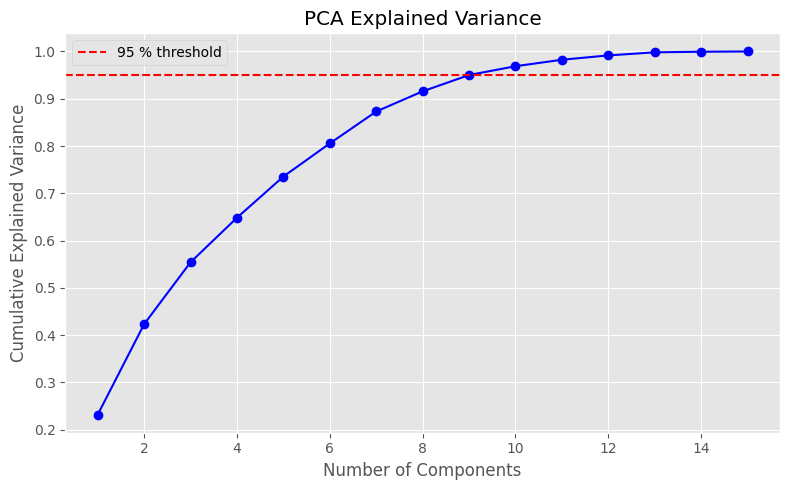

Components explaining >= 95 % variance: 9


In [103]:
# Cumulative variance explained
explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95 % threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

n_comp = np.argmax(explained_var >= 0.95) + 1
print(f'Components explaining >= 95 % variance: {n_comp}')

---
## 15. Conclusion

- We performed exhaustive data analysis, stationarity tests, and decomposition.
- Multiple forecasting models were implemented and evaluated with proper time-based validation.
- XGBoost delivered the best performance on the validation set, with low MAE and RMSE.
- Residual analysis showed some remaining autocorrelation, suggesting potential for further improvement.
- The pipeline can be extended to other locations and refined with hyperparameter tuning and ensemble methods.

All code is modular and ready for production deployment.